## Echopype demonstration notebook 2
# Wacthing a solar eclipse using a moored echosounder

Jupyter notebook accompanying the manuscript:

_Echopype: A Python library for interoperable and scalable processing of ocean sonar data for biological information_    
_Authors: Wu-Jung Lee, Emilio Mayorga, Landung Setiawan, Kavin Nguyen, Imran Majeed, Valentina Staneva_

### Goals

- Illustrate a common workflow for echosounder data conversion, calibration and use. This workflow leverages the standardization applied by echopype. and the power, ease of use and familiarity of libraries in the scientific Python ecosystem. 
- Demonstrate the ease to interoperate echosounder data with those from a different instrument in a single computing environment. Without `echopype`, additional wrangling across more than one software systems is needed to achieve the same visualization and comparison.


### Description

This notebook uses EK60 echosounder data from the U.S. [Ocean Observatories Initiative (OOI)](https://oceanobservatories.org/) to illustrate a common workflow for data conversion, combination, calibration and analysis using [`echopype`](https://echopype.readthedocs.io), as well as the data interoperability it enables. Without `echopype`, additional wrangling across more than one software systems is needed to achieve the same visualization and comparison.

We will use data from the OOI [Oregon Offshore Cabled Shallow Profiler Mooring](https://oceanobservatories.org/site/ce04osps/) collected on August 20-21, 2017. This was the day before and of a solar eclipse, during which the reduced sunlight affected the regular diel vertical migration (DVM) patterns of marine life. This change was directly observed using the upward-looking echosounder mounted on this mooring platform that happened to be within the totality zone. The effect of the solar eclipse was clearly seen by aligning and comparing the echosounder observations with solar radiation data collected by the Bulk Meteorology Instrument Package located on the nearby [Coastal Endurance Oregon Offshore Surface Mooring](https://oceanobservatories.org/site/ce04ossm/), also maintained by the OOI. 

The data used are XXX `.raw` files with a total volume of XX GB. With `echopype` functionality, the raw data files hosted on the [OOI Raw Data Archive](https://rawdata.oceanobservatories.org/files/) (an HTTP server) are directly parsed and organized into a standardized representation following in the [SONAR-netCDF4 v1.0 convention](https://github.com/ices-publications/SONAR-netCDF4/), and stored to the cloud-optimized [Zarr](https://zarr.readthedocs.io) format. The inidivudal converted files are later combined into a single entity that can be easily explored and manipulated.


### Outline

1. Establish connection with the OOI Raw Data Archive and generate list of target EK60 `.raw` files
2. Process the archived raw files with `echopype`: convert and combine into a single quantity (an `EchoData` object) in a standardized format.
3. Obtain solar radiation data from an OOI Thredds server.
4. Plot the echosounder and solar radiation data together to visualize the zooplankton response to a solar eclipse.

### Running the notebook

This notebook can be run with a conda environment created using the conda environment file https://github.com/OSOceanAcoustics/echopype-examples/blob/echopype_paper/binder/environment.yml. The notebook creates a directory `./exports/ooifiles` and save all generated Zarr and netCDF files there.

**Note**: we encourage importing `echopype` as `ep` for consistency.

In [1]:
from pathlib import Path
import itertools as it
import datetime as dt
from dateutil import parser as dtparser

import fsspec
import xarray as xr
import matplotlib.pyplot as plt
import hvplot.xarray

import echopype as ep

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

## Establish connection with the OOI Raw Data Archive and generate list of target EK60 `.raw` files

Access and inspect the publicly accessible OOI Raw Data Archive (an HTTP server) as if it were a local file system. This will be done through the Python [fsspec](https://filesystem-spec.readthedocs.io) file system and bytes storage interface. We will use `fsspec.filesystem.glob` (`fs.glob`) to generate a list of all EK60 `.raw` data files in the archive then filter on file names for target dates of interest. 

In [2]:
fs = fsspec.filesystem('https')

In [3]:
ooi_raw_url = (
    "https://rawdata.oceanobservatories.org/files/"
    "CE04OSPS/PC01B/ZPLSCB102_10.33.10.143/2017/08"
)

Now let's specify the range of dates we will be pulling data from. Note that the data filenames contain the time information but were recorded at UTC time.

In [4]:
def in_range(raw_file: str, start: dt.datetime, end: dt.datetime) -> bool:
    """Check if file url is in date range"""
    file_name = Path(raw_file).name
    # file_name = os.path.basename(raw_file)
    file_datetime = dtparser.parse(file_name, fuzzy=True)
    return file_datetime >= start and file_datetime <= end

In [39]:
start_datetime = dt.datetime(2017, 8, 21, 7, 0)
end_datetime = dt.datetime(2017, 8, 22, 7, 0)

On the OOI Raw Data Archive, the monthly folder is further split to daily folders, so we can simply grab data from the desired days.

In [6]:
desired_day_urls = [f"{ooi_raw_url}/{day}" for day in range(start_datetime.day, end_datetime.day + 1)]

In [7]:
desired_day_urls

['https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143/2017/08/21',
 'https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143/2017/08/22']

Grab all raw files within daily folders by using the filesytem glob, just like the Linux `glob`.

In [8]:
all_raw_file_urls = it.chain.from_iterable([fs.glob(f"{day_url}/*.raw") for day_url in desired_day_urls])

In [9]:
desired_raw_file_urls = list(filter(
    lambda raw_file: in_range(raw_file, start_datetime, end_datetime), all_raw_file_urls
))

print(f"There are {len(desired_raw_file_urls)} raw files within the specified date range.")

There are 15 raw files within the specified date range.


## Process the archived raw files with `echopype`

### Examine the workflow by processing just one file

Let's first test the `echopype` workflow by converting and processing 1 file from the above list. 

We will use `ep.open_raw` to directly read in a raw data file from the OOI HTTP server. 

The type of sonar needs to be specified as an input argument. The echosounders on the OOI Regional Cabled Array are [Simrad EK60 echosounder](https://www.kongsberg.com/maritime/products/ocean-science/fishery-research/es_scientific/simrad-ek60/). All other uncabled echosounders are the [Acoustic Zooplankton and Fisher Profiler (AZFP)](https://aslenv.com/azfp.html) manufacturered by ASL Environmental Sciences. `Echopype` supports both of these and other instruments (see [echopype documentation](https://echopype.readthedocs.io/en/stable/index.html) for detail).

### Converting from raw data files to a standardized data format

Below we already know the path to the 1 file on the http server:

In [10]:
echodata = ep.open_raw(raw_file=desired_raw_file_urls[0], sonar_model="ek60")

12:03:17  parsing file OOI-D20170821-T081522.raw, time of first ping: 2017-Aug-21 08:15:22


Here `echopype` read, parse, and convert content of the raw file into memory, and gives you a nice representation of the converted file below as a Python `EchoData` object.

In [11]:
echodata

EchoData: standardized raw data from Internal Memory
  > top: (Top-level) contains metadata about the SONAR-netCDF4 file format.
  > environment: (Environment) contains information relevant to acoustic propagation through water.
  > platform: (Platform) contains information about the platform on which the sonar is installed.
  > nmea: (Platform/NMEA) contains information specific to the NMEA protocol.
  > provenance: (Provenance) contains metadata about how the SONAR-netCDF4 version of the data were obtained.
  > sonar: (Sonar) contains specific metadata for the sonar system.
  > beam: (Beam) contains backscatter data and other beam or channel-specific data.
  > vendor: (Vendor specific) contains vendor-specific information about the sonar and the data.

The `EchoData` object can be saved to either the `netCDF4` or `zarr` formats through `to_netcdf` or `to_zarr` methods.

In [12]:
# Create directories for files genereated in this notebook.
base_dpath = Path('./exports')
base_dpath.mkdir(exist_ok=True)

output_dpath = Path(base_dpath / 'ooimooring_onefiletest')
output_dpath.mkdir(exist_ok=True)

In [13]:
# Save to netCDF format
echodata.to_netcdf(save_path=output_dpath, overwrite=True)

12:03:45  saving exports/ooimooring_onefiletest/OOI-D20170821-T081522.nc


In [14]:
# Save to zarrr format
echodata.to_zarr(save_path=output_dpath, overwrite=True)

12:03:53  saving exports/ooimooring_onefiletest/OOI-D20170821-T081522.zarr


### Basic echo processing

At present `echopype` supports basic processing funcionalities including calibration (from raw instrument data records to volume backscattering strength, $S_V$), denoising, and computing mean volume backscattering strength, $\overline{S_V}$ or $\text{MVBS}$. The `Echodata` object can be passed into various calibrate and preprocessing functions without having to write out any intermediate files.

Here we demonstrate calibration to obtain $S_V$. For EK60 data, by default the function uses environmental (sound speed and absorption) and calibration parameters stored in the data file. Users can optionally specify other parameter choices.

In [15]:
# Compute volume backscattering strength (Sv) from raw data
ds_Sv = ep.calibrate.compute_Sv(echodata)

The computed `Sv` is stored with other variables used in the calibration operation.

In [16]:
ds_Sv

<xarray.Dataset>
Dimensions:                (frequency: 3, ping_time: 5922, range_bin: 1072)
Coordinates:
  * frequency              (frequency) float64 3.8e+04 1.2e+05 2e+05
  * ping_time              (ping_time) datetime64[ns] 2017-08-21T08:15:22.981...
  * range_bin              (range_bin) int64 0 1 2 3 4 ... 1068 1069 1070 1071
Data variables:
    Sv                     (frequency, ping_time, range_bin) float64 3.827 .....
    range                  (frequency, ping_time, range_bin) float64 0.0 ... ...
    temperature            object None
    salinity               object None
    pressure               object None
    sound_speed            (frequency, ping_time) float64 1.494e+03 ... 1.494...
    sound_absorption       (frequency, ping_time) float64 0.009785 ... 0.05269
    sa_correction          (frequency) float64 0.0 0.0 0.0
    gain_correction        (frequency) float64 26.5 25.0 25.0
    equivalent_beam_angle  (frequency) float64 -20.6 -20.7 -20.7

### Quickly visualize the result

The default `xarray` visualization functions are useful in getting a quick sense of the data. 

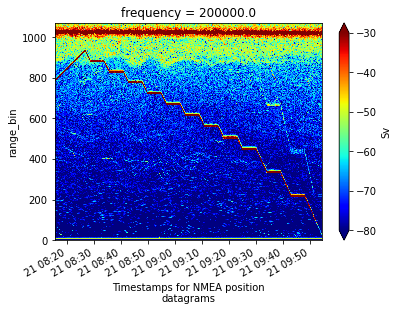

In [17]:
ds_Sv.Sv.sel(frequency=200000).plot.pcolormesh(
    x='ping_time', cmap = 'jet', vmin=-80, vmax=-30)

Note that the vertical axis is `range_bin`. This is the bin (or sample) number as recorded in the data. A separate data variable in `ds_Sv` contains the physical `range` from the transducer in meters. `range` has the same dimension as `Sv` and may not be uniform across all frequency channels or pings, depending on the echosounder setting during data collection.

### Convert multiple files and combine into a single `EchoData` object

Now that we verified that `echopype` does work for a single file, let's proceed to process all sonar data from August 20-21, 2017.

First, convert all desired files from the OOI HTTP server to a local directory `./exports/ooimooring_allfiles`. 

In [18]:
# Create a directory for all files
output_dpath = Path(base_dpath / 'ooimooring_allfiles')
output_dpath.mkdir(exist_ok=True)

In [19]:
%%time
for raw_file_url in desired_raw_file_urls:
    # Read and convert, resulting in echodata object
    ed = ep.open_raw(raw_file=raw_file_url, sonar_model='ek60')
    ed.to_zarr(save_path=output_dpath, overwrite=True)

12:04:01  parsing file OOI-D20170821-T081522.raw, time of first ping: 2017-Aug-21 08:15:22
12:04:26  overwriting exports/ooimooring_allfiles/OOI-D20170821-T081522.zarr
12:04:31  parsing file OOI-D20170821-T095435.raw, time of first ping: 2017-Aug-21 09:54:35
12:04:53  overwriting exports/ooimooring_allfiles/OOI-D20170821-T095435.zarr
12:04:58  parsing file OOI-D20170821-T113343.raw, time of first ping: 2017-Aug-21 11:33:43
12:05:24  overwriting exports/ooimooring_allfiles/OOI-D20170821-T113343.zarr
12:05:31  parsing file OOI-D20170821-T131245.raw, time of first ping: 2017-Aug-21 13:12:45
12:05:54  overwriting exports/ooimooring_allfiles/OOI-D20170821-T131245.zarr
12:05:58  parsing file OOI-D20170821-T145147.raw, time of first ping: 2017-Aug-21 14:51:47
12:06:20  overwriting exports/ooimooring_allfiles/OOI-D20170821-T145147.zarr
12:06:24  parsing file OOI-D20170821-T163049.raw, time of first ping: 2017-Aug-21 16:30:49
12:06:47  overwriting exports/ooimooring_allfiles/OOI-D20170821-T1630

Then, assemble a list of `EchoData` object from the converted files. Note that be default the files are _lazy-loaded_ and only metadata are read into memory, until more operations are executed.

In [20]:
# Use fsspec locally to assemble a list of converted files
fs_local = fsspec.filesystem('file')

In [21]:
ed_list = []
for converted_file in fs_local.glob(output_dpath / f"*.zarr"):
    ed_list.append(ep.open_converted(converted_file))

Combine all the opened files to a single `EchoData` object in memory. This will take a bit of time to execute.

In [22]:
ed = ep.combine_echodata(ed_list)

### Calibrate the combined `EchoData` and visualize the mean Sv

The single `EchoData` object is convenient to use for content inspection and calibration.

In [23]:
ds_Sv = ep.calibrate.compute_Sv(ed)

Next, compute the mean Sv (MVBS) with coherent dimensions along physically meaning `range` (in meters) and `ping_time` from the calibrated data. This processed dataset is easy to visualize. The average bin size along `ping_time` can be specified using the [offset alias](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases).

In [24]:
ds_MVBS = ep.preprocess.compute_MVBS(
    ds_Sv, 
    range_meter_bin=0.2,  # 0.2 meters
    ping_time_bin='10S'   # 10 seconds
)

The resulting MVBS Dataset has a coherent `range` coorindate across all frequencies.

In [25]:
ds_MVBS

<xarray.Dataset>
Dimensions:    (ping_time: 17876, frequency: 3, range: 1023)
Coordinates:
  * ping_time  (ping_time) datetime64[ns] 2017-08-20T06:35:50 ... 2017-08-22T...
  * frequency  (frequency) float64 3.8e+04 1.2e+05 2e+05
  * range      (range) float64 0.0 0.2 0.4 0.6 0.8 ... 203.8 204.0 204.2 204.4
Data variables:
    Sv         (frequency, ping_time, range) float64 10.3 2.976 ... -53.11
Attributes:
    binning_mode:          physical units
    range_meter_interval:  0.2m
    ping_time_interval:    10S

### Visualize MVBS interactively using `hvPlot`

To visualize, invert the `range` axis since the echosounder is upward-looking from a platform at approximately 200 m water depth.

In [26]:
ds_MVBS = ds_MVBS.assign_coords(depth=("range", ds_MVBS["range"].values[::-1]))
ds_MVBS = ds_MVBS.swap_dims({'range': 'depth'})  # set depth as data dimension

In [27]:
ds_MVBS["Sv"].sel(frequency=200000).hvplot.image(
    x='ping_time', y='depth', 
    color='Sv', rasterize=True, 
    cmap='jet', clim=(-80, -30),
    xlabel='Time (UTC)',
    ylabel='Depth (m)'
).options(width=800, invert_yaxis=True)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


:DynamicMap   []
   :Image   [ping_time,depth]   (Sv)

Note that the reflection from the sea surface shows up at a location below the depth of 0 m. This is because we have not corrected for the actual depth of the platform on which the echosounder is mounted, and the actual sound speed at the time of data collection (which is related to the calculated range) could also be different from the user-defined sound speed stored in the data file. More accurate platform depth information can be obtained using data from the CTD collocated on the moored platform.

## Obtain solar radiation data from an OOI Thredds server

Now we have the sonar data ready, the next step is to pull solar radiation data collected by a nearby surface mooring also maintained by the OOI. The Bulk Meteorology Instrument Package is located on the [Coastal Endurance Oregon Offshore Surface Mooring](https://oceanobservatories.org/site/ce04ossm/). 

Note: an earlier version of this notebook used the same dataset but pulled from the National Data Buoy Center (NDBC). We thank the Rutgers OOI Data Lab for pointing out the direct data source in [one of the data nuggets](https://datalab.marine.rutgers.edu/data-nuggets/zooplankton-eclipse/).

In [28]:
metbk_url = (
    "http://thredds.dataexplorer.oceanobservatories.org/thredds/dodsC/ooigoldcopy/public/"
    "CE04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/"
    "deployment0004_CE04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered_20170421T022518.003000-20171013T154805.602000.nc#fillmismatch"
)

In [29]:
metbk_ds = (
    xr.open_dataset(metbk_url)
    .swap_dims({'obs': 'time'})
    .drop('obs')
    .sel(time=slice(start_datetime, end_datetime))[['shortwave_irradiance']]
)
metbk_ds.time.attrs.update({'long_name': 'Time', 'units': 'UTC'})

metbk_ds

<xarray.Dataset>
Dimensions:               (time: 1441)
Coordinates:
  * time                  (time) datetime64[ns] 2017-08-21T07:00:08.232999936...
Data variables:
    shortwave_irradiance  (time) float32 ...
Attributes: (12/73)
    node:                               SBD11
    comment:                            
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             metbk_a_dcl_instrument_recovered
    ...                                 ...
    geospatial_vertical_positive:       down
    lat:                                44.36555
    lon:                                -124.9407
    DODS.strlen:                        14
    DODS.dimName:                       string14
    DODS_EXTRA.Unlimited_Dimension:     obs

## Combine sonar observation with solar radiation measurements

We can finally put everything together and figure out the impact of the eclipse-driven reduction in sunlight on marine zooplankton!

In [40]:
metbk_plot = metbk_ds.hvplot.line(
    x='time', y='shortwave_irradiance'
).options(width=800, height=200, logy=True, xlim=(start_datetime, end_datetime))

mvbs_plot = ds_MVBS["Sv"].sel(frequency=200000).hvplot.image(
    x='ping_time', y='depth', 
    color='Sv', rasterize=True, 
    cmap='jet', clim=(-80, -30),
    xlabel='Time (UTC)',
    ylabel='Depth (m)'
).options(width=800, invert_yaxis=True, xlim=(start_datetime, end_datetime))

In [41]:
(metbk_plot + mvbs_plot).cols(1)

:Layout
   .Curve.I      :Curve   [time]   (shortwave_irradiance)
   .DynamicMap.I :DynamicMap   []
      :Image   [ping_time,depth]   (Sv)

Look how the dip at solar radiation reading matches exactly with the upwarding moving "blip" at UTC 17:21, August 22, 2017 (local time 10:22 AM), whereas on the previous day, the animals underwent the regular DVM cycle. During the solar eclipse, the animals were fooled by the temporary mask of the sun and thought it's getting dark as at dusk!

## Package versions

In [32]:
print(f"echopype: {ep.__version__}, xarray: {xr.__version__}, fsspec: {fsspec.__version__}, hvplot: {hvplot.__version__}")

echopype: 0.5.4.dev12+g19b9c50, xarray: 0.19.0, fsspec: 2021.09.0, hvplot: 0.7.3


In [33]:
import datetime
print(f"{datetime.datetime.utcnow()} +00:00")

2021-09-30 19:17:14.687824 +00:00
